In [1]:
!ls ../input/train/ -l

PATH = '../input/train/'

import pandas as pd
import numpy as np

import warnings

warnings.filterwarnings("ignore")

pd.set_option('max.columns', 100)

import missingno as msno

%pylab inline
import seaborn as sns

from datetime import datetime

import warnings
from tqdm import tqdm

import xgboost as xgb
import lightgbm as lgb
import catboost as cab

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


Populating the interactive namespace from numpy and matplotlib


# 赛题介绍

- `赛题名`：企业非法集资风险预测

- `背景`：非法集资严重干扰了正常的经济、金融秩序，使参与者遭受经济损失，甚至生活陷入困境，极易引发社会不稳定和大量社会治安问题，甚至引发局部地区的社会动荡。如何根据大量的企业信息建立预测模型并判断企业是否存在非法集资风险，对监管部门、企业合作伙伴、投资者都具有一定的价值。

- `任务`：利用机器学习、深度学习等方法训练一个预测模型，该模型可学习企业的相关信息，**以预测企业是否存在非法集资风险**。赛题的难点在于数据集包括大量的企业相关信息，如何从中提取有效的特征并进行风险预测成为本赛题的关键问题。

- `出题单位`：中科大智慧城市研究院



# 数据读取&分析

该数据集包含约25000家企业数据，其中约15000家企业带标注数据作为训练集，剩余数据作为测试集。数据由企业基本信息、企业年报、企业纳税情况等组成，数据包括数值型、字符型、日期型等众多数据类型（已脱敏），部分字段内容在部分企业中有缺失，其中第一列id为企业唯一标识。

## 数据说明

### 数据集1：base_info.csv

包含数据集7和8中涉及到的所有企业的基本信息，每一行代表一个企业的基本数据，每一行有33列，其中id列为企业唯一标识，列之间采用“,”分隔符分割。

数据格式如下：

|   列名   |  含义    |   列名   |   含义   |   列名   |  含义    |   列名   |   含义   | 
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| id | 企业唯一标识 | oplocdistrict | 行政区划代码 | industryphy | 行业类别代码 | industryco | 行业细类代码 |
| dom | 经营地址 | opscope | 经营范围 | enttype | 企业类型 | enttypeitem | 企业类型小类 |
| opfrom | 经营期限起 | opto | 经营期限止 | state | 状态 | orgid | 机构标识 |
| jobid | 职位标识 | adbusign | 是否广告经营 | townsign | 是否城镇 | regtype | 主题登记类型 |
| empnum | 从业人数 | compform | 组织形式 | parnum | 合伙人数 | exenum | 执行人数 |
| opform | 经营方式 | ptbusscope | 兼营范围 | venind | 风险行业 | enttypeminu | 企业类型细类 |
| midpreindcode | 中西部优势产业代码 | protype | 项目类型 | oploc | 经营场所 | regcap | 注册资本（金） |
| reccap | 实缴资本 | forreccap | 实缴资本（外方） | forregcap | 注册资本（外方） | congro | 投资总额 |
| enttypegb | 企业（机构）类型 |

In [2]:
base_info = pd.read_csv(PATH + 'base_info.csv')

print(base_info.shape, base_info['id'].nunique())
base_info.head(1)

(24865, 33) 24865


,id,oplocdistrict,industryphy,industryco,dom,opscope,enttype,enttypeitem,opfrom,opto,state,orgid,jobid,adbusign,townsign,regtype,empnum,compform,parnum,exenum,opform,ptbusscope,venind,enttypeminu,midpreindcode,protype,oploc,regcap,reccap,forreccap,forregcap,congro,enttypegb
0,47645761dc56bb8c5fae00114b768b5d9b6e917c3aec07c4,340223,M,7513.0,31487d8f256f16bd6244b7251be2ebb24d1db51663c654...,纳米新材料、机械设备、五金配件加工、销售及技术推广服务，道路货物运输。（依法须经批准的项目，...,1100,1150.0,2019-07-11 00:00:00,NaN,6,340223010010000000,340200000000115392,0,0,1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1151.0,NaN,NaN,2367b4cac96d8598,50.0,NaN,NaN,NaN,NaN,1151


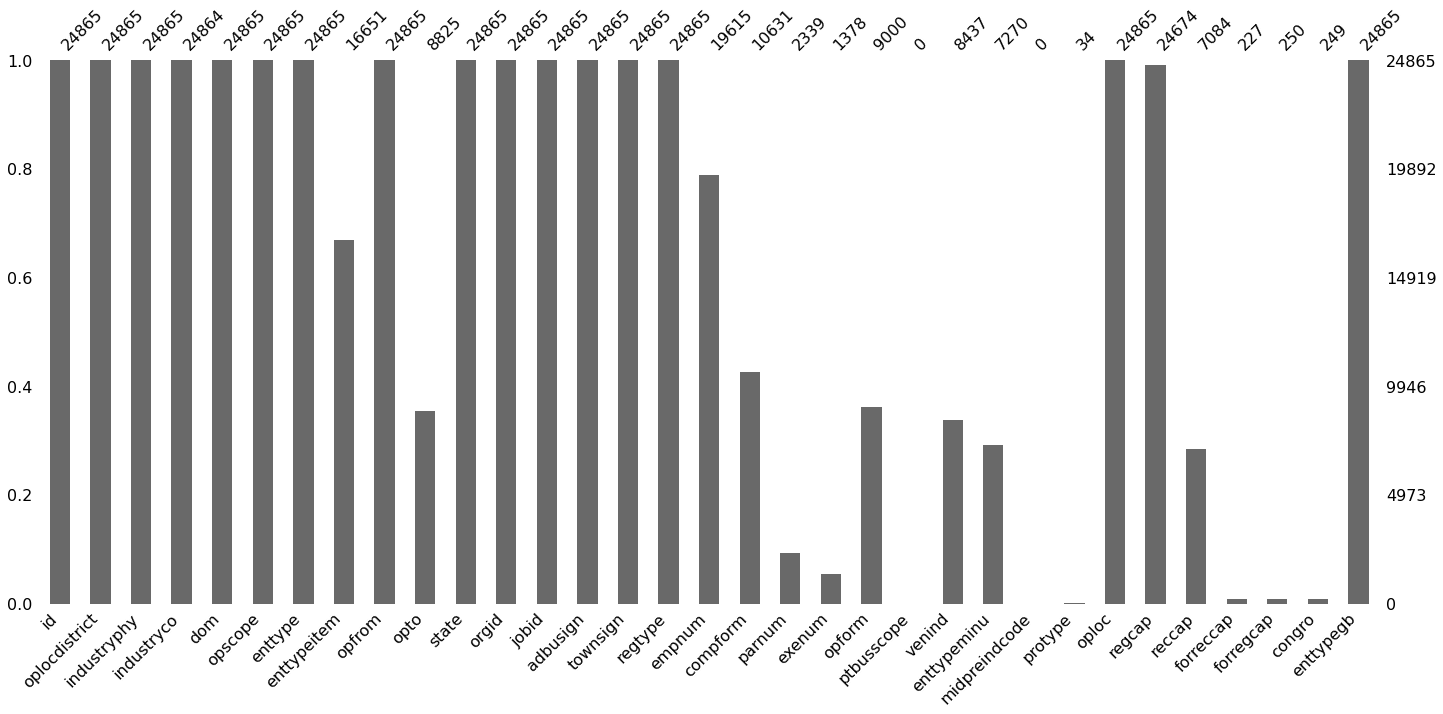

In [3]:
# 缺失值
msno.bar(base_info)

In [4]:
for col in base_info.columns:
    print(col, base_info[col].nunique())

id 24865
oplocdistrict 16
industryphy 20
industryco 345
dom 23278
opscope 20815
enttype 17
enttypeitem 31
opfrom 6620
opto 5746
state 6
orgid 78
jobid 434
adbusign 2
townsign 2
regtype 3
empnum 62
compform 2
parnum 51
exenum 50
opform 33
ptbusscope 0
venind 3
enttypeminu 26
midpreindcode 0
protype 2
oploc 5351
regcap 1143
reccap 597
forreccap 11
forregcap 38
congro 33
enttypegb 53


In [5]:
base_info.corr()

,oplocdistrict,industryco,enttype,enttypeitem,state,orgid,jobid,adbusign,townsign,regtype,empnum,compform,parnum,exenum,ptbusscope,venind,enttypeminu,midpreindcode,protype,regcap,reccap,forreccap,forregcap,congro,enttypegb
oplocdistrict,1.000000,0.112593,0.121533,-0.041273,0.019492,-0.020198,0.078328,-0.008561,-0.033043,-0.042385,0.024939,0.028629,-0.073539,-0.008300,NaN,-0.081515,-0.176448,NaN,0.005271,-0.041067,-0.042661,-0.104363,-0.077224,-0.078097,0.121500
industryco,0.112593,1.000000,0.257469,-0.094717,0.030038,0.056266,0.048277,-0.002085,-0.058483,-0.051295,-0.044818,0.008104,-0.214439,-0.018191,NaN,-0.068183,-0.461538,NaN,-0.111578,-0.106896,-0.090893,-0.372025,-0.279505,-0.308839,0.257281
enttype,0.121533,0.257469,1.000000,0.999932,-0.027878,0.179735,-0.178680,-0.042500,0.346220,-0.097321,-0.034183,0.023962,0.261070,-0.000758,NaN,0.275222,0.999996,NaN,-0.086552,-0.008691,0.094448,0.212679,0.184072,0.184857,0.999995
enttypeitem,-0.041273,-0.094717,0.999932,1.000000,-0.010287,0.026695,-0.166773,-0.025031,0.224193,-0.032974,0.021419,NaN,0.260897,-0.000758,NaN,0.162243,1.000000,NaN,-0.082266,0.158789,0.100358,0.454545,0.317294,0.321941,1.000000
state,0.019492,0.030038,-0.027878,-0.010287,1.000000,-0.010450,-0.025917,0.005841,0.055396,-0.001333,-0.009471,0.016457,-0.012364,-0.004302,NaN,-0.022642,-0.083751,NaN,0.144005,-0.016389,-0.029711,-0.046624,-0.041558,-0.043007,-0.027873
orgid,-0.020198,0.056266,0.179735,0.026695,-0.010450,1.000000,0.100055,-0.007011,0.059033,-0.014396,-0.012030,0.014091,-0.059041,-0.008210,NaN,-0.023426,-0.134803,NaN,0.102869,-0.010051,-0.001102,0.003824,0.003426,0.003553,0.179710
jobid,0.078328,0.048277,-0.178680,-0.166773,-0.025917,0.100055,1.000000,-0.022339,-0.274408,-0.013339,0.018536,-0.007621,-0.246189,-0.008265,NaN,-0.009625,-0.245806,NaN,-0.080584,-0.028447,-0.017728,-0.019219,0.000662,0.013314,-0.178719
adbusign,-0.008561,-0.002085,-0.042500,-0.025031,0.005841,-0.007011,-0.022339,1.000000,-0.016126,-0.003955,-0.013402,-0.003266,NaN,NaN,NaN,NaN,-0.021901,NaN,NaN,-0.000085,0.002786,-0.032364,-0.028940,-0.030020,-0.042538
townsign,-0.033043,-0.058483,0.346220,0.224193,0.055396,0.059033,-0.274408,-0.016126,1.000000,-0.072162,-0.028617,0.007102,0.253791,0.012175,NaN,0.010278,0.372428,NaN,NaN,0.039094,0.027127,-0.077001,-0.068255,-0.070828,0.346336
regtype,-0.042385,-0.051295,-0.097321,-0.032974,-0.001333,-0.014396,-0.013339,-0.003955,-0.072162,1.000000,0.002866,0.008554,0.063020,-0.003083,NaN,-0.067663,-0.068709,NaN,-0.424139,0.002011,0.022605,0.083947,0.142100,0.142878,-0.097343


### 数据集2：annual_report_info.csv

包含数据集7和8中涉及到的企业的年报基本信息，每一行代表一个企业的年报基本数据，每一行有23列，其中id列为企业唯一标识，列之间采用“,”分隔符分割。

数据格式如下：

|   列名   |  含义    |   列名   |   含义   | 
| ---- | ---- | ---- | ---- |
| id | 企业唯一标识 | ANCHEYEAR | 年度 |
| STATE | 状态 | FUNDAM | 资金数额 |
| MEMNUM | 成员人数 | FARNUM | 农民人数 |
| ANNNEWMEMNUM | 本年度新增成员人数 | ANNREDMEMNUM | 本年度退出成员人数 |
| EMPNUM | 从业人数 | EMPNUMSIGN | 从业人数是否公示 |
| BUSSTNAME | 经营状态名称 | COLGRANUM | 其中高校毕业生人数经营者 |
| RETSOLNUM | 其中退役士兵人数经营者 | DISPERNUM | 其中残疾人人数经营者 |
| UNENUM | 其中下岗失业人数经营者 | COLEMPLNUM | 其中高校毕业生人数雇员 |
| RETEMPLNUM | 其中退役士兵人数雇员 | DISEMPLNUM | 其中残疾人人数雇员 |
| UNEEMPLNUM | 其中下岗失业人数雇员 | WEBSITSIGN | 是否有网站标志 |
| FORINVESTSIGN | 是否有对外投资企业标志 | STOCKTRANSIGN | 有限责任公司本年度是否发生股东股权转让标志 |
| PUBSTATE | 公示状态：1 全部公示，2部分公示，3全部不公示|

In [6]:
annual_report_info = pd.read_csv(PATH + 'annual_report_info.csv')
print(annual_report_info.shape, annual_report_info['id'].nunique())

annual_report_info.head()

(22550, 23) 8937


,id,ANCHEYEAR,STATE,FUNDAM,MEMNUM,FARNUM,ANNNEWMEMNUM,ANNREDMEMNUM,EMPNUM,EMPNUMSIGN,BUSSTNAME,COLGRANUM,RETSOLNUM,DISPERNUM,UNENUM,COLEMPLNUM,RETEMPLNUM,DISEMPLNUM,UNEEMPLNUM,WEBSITSIGN,FORINVESTSIGN,STOCKTRANSIGN,PUBSTATE
0,9c7fa510616a683058ce97d0bc768a621cd85ab1e87da2a3,2017.0,2.0,5.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,3.0
1,9c7fa510616a683058ce97d0bc768a621cd85ab1e87da2a3,2018.0,2.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,3.0
2,f000950527a6feb63ee1ce82bb22ddd1ab8b8fdffa3b91fb,2017.0,2.0,NaN,NaN,NaN,NaN,NaN,4.0,2.0,开业,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,3.0
3,f000950527a6feb63ee1ce82bb22ddd1ab8b8fdffa3b91fb,2018.0,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,开业,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,3.0
4,9c7fa510616a68309e4badf2a7a3123c0462fb85bf28ef17,2017.0,2.0,5.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,3.0


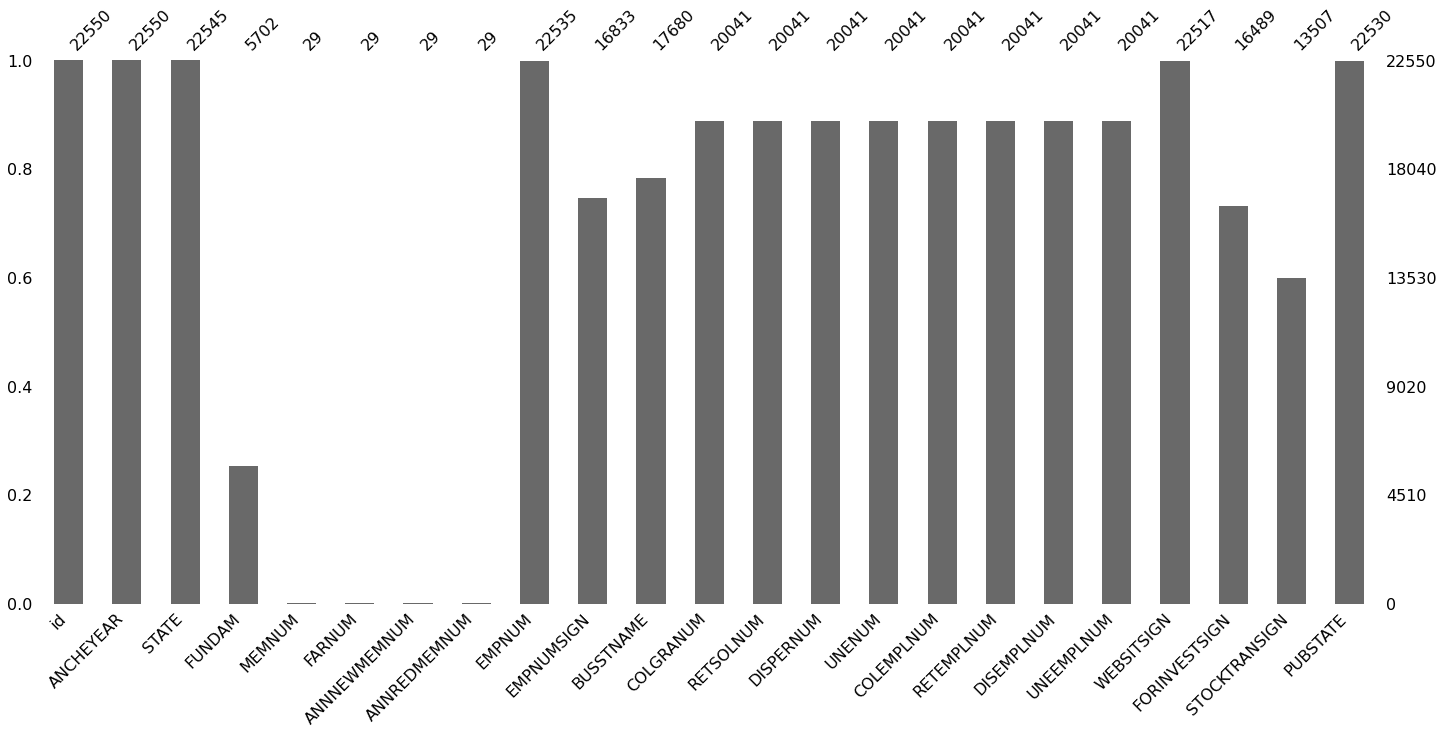

In [7]:
# 缺失值
msno.bar(annual_report_info)

### 数据集3：tax_info.csv

包含数据集7和8中涉及到的企业的纳税信息，每一行代表一个企业的纳税信息，每一行有9列，其中id列为企业唯一标识，列之间采用“,”分隔符分割。

数据格式如下：

|   列名   |  含义    |   列名   |   含义   | 
| ---- | ---- | ---- | ---- |
| id | 企业唯一标识 | START_DATE | 起始时间 |
| END_DATE | 终止时间 |  TAX_CATEGORIES | 税种 |
| TAX_ITEMS | 税目 | TAXATION_BASIS | 计税依据 |
| TAX_RATE | 税率 | DEDUCTION | 扣除数 |
| TAX_AMOUNT | 税额 | | 

In [8]:
tax_info = pd.read_csv(PATH + 'tax_info.csv')
print(tax_info.shape, tax_info['id'].nunique())

tax_info.head()

(29195, 9) 808


,id,START_DATE,END_DATE,TAX_CATEGORIES,TAX_ITEMS,TAXATION_BASIS,TAX_RATE,DEDUCTION,TAX_AMOUNT
0,f000950527a6feb6c2f40c9d8477e73a439dfa0897830397,2015/09/01,2015/09/30,印花税,工伤保险（单位）,72530.75,0.0003,-0.04,21.8
1,f000950527a6feb6c2f40c9d8477e73a439dfa0897830397,2015/09/01,2015/09/30,印花税,失业保险（单位）,72530.75,0.0003,-0.04,21.8
2,f000950527a6feb6c2f40c9d8477e73a439dfa0897830397,2015/09/01,2015/09/30,印花税,医疗保险（单位）,72530.75,0.0003,-0.04,21.8
3,f000950527a6feb6c2f40c9d8477e73a439dfa0897830397,2015/09/01,2015/09/30,印花税,企业养老保险基金（单位）,72530.75,0.0003,-0.04,21.8
4,f000950527a6feb6c2f40c9d8477e73a439dfa0897830397,2015/09/01,2015/09/30,印花税,烟叶收购,72530.75,0.0003,-0.04,21.8


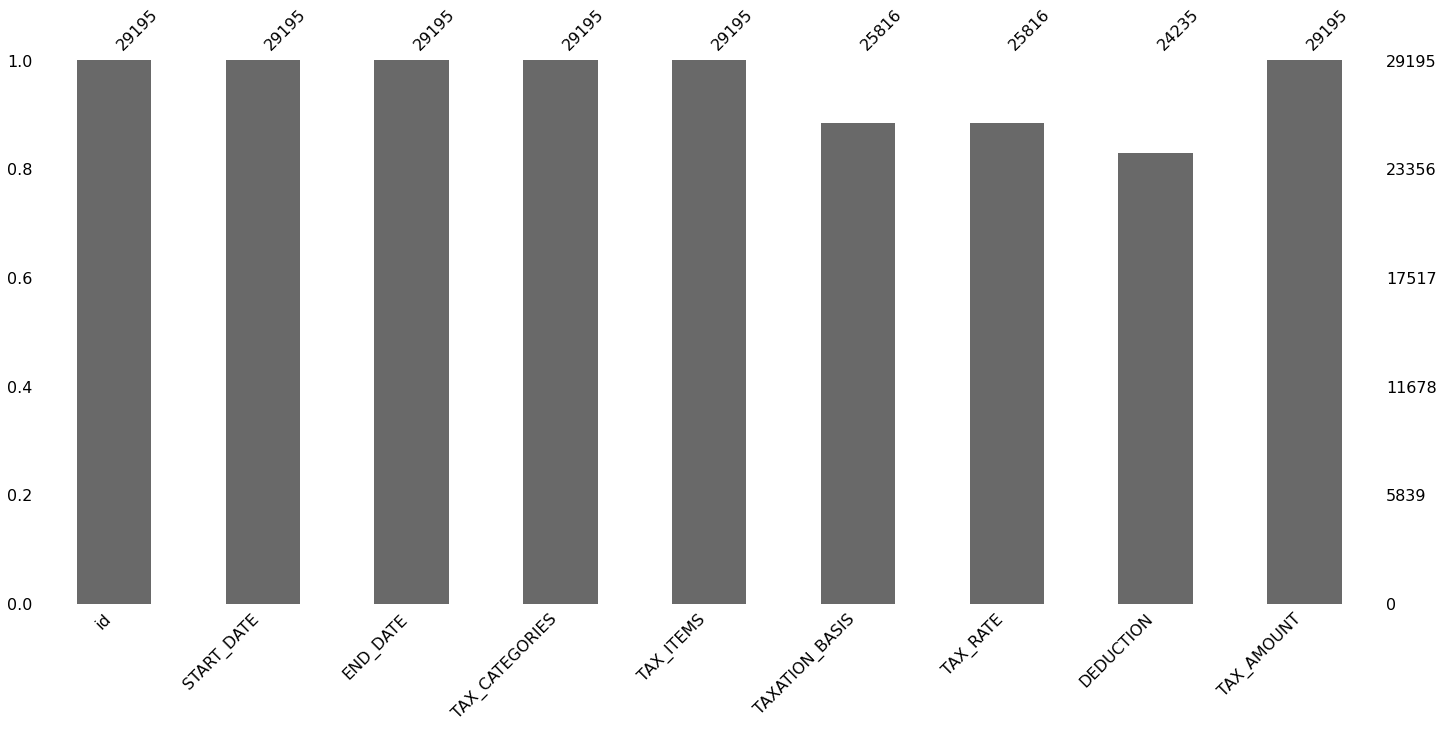

In [9]:
# 缺失值
msno.bar(tax_info)

### 数据集4：change_info.csv

包含数据集7和8中涉及到的企业的变更信息，每一行代表一个企业变更信息，每一行5列，其中id列为企业唯一标识，列之间采用“,”分隔符分割。

数据格式如下：

|   列名   |  含义    |   列名   |   含义   | 
| ---- | ---- | ---- | ---- |
| id | 企业唯一标识 | bgxmdm | 变更信息代码 |
| bgq | 变更前 | bgh | 变更后 |
| bgrq | 变更日期 | |

In [10]:
change_info = pd.read_csv(PATH + 'change_info.csv')
change_info.head()

,id,bgxmdm,bgq,bgh,bgrq
0,9c7fa510616a683058ce97d0bc768a621cd85ab1e87da2a3,939.0,9dec12da51cdb672a91b4a8ae0e0895f7bfeb243dfa3e0c8,9dec12da51cdb672a91b4a8ae0e0895f4a56cbe3deca98...,2.019060e+13
1,9c7fa510616a683058ce97d0bc768a621cd85ab1e87da2a3,112.0,31487d8f256f16bd6244b7251be2ebb27b17bdfd95c8f3...,31487d8f256f16bd6244b7251be2ebb27b17bdfd95c8f3...,2.019060e+13
2,e9f7b28ec10e047000d16ab79e1b5e6da434a1697cce7818,111.0,54ca436ffb87f24c820178b45fcc3a7b,f80e3376abcf81ad2a279d6d99046153,2.017013e+13
3,e9f7b28ec10e047000d16ab79e1b5e6da434a1697cce7818,128.0,f1fdb1c866dc96638cbfb8b788b91393,1eca8a0d8beca58d988f7dccab5dc868,2.017013e+13
4,e9f7b28ec10e047000d16ab79e1b5e6da434a1697cce7818,925.0,54ca436ffb87f24c820178b45fcc3a7b,f80e3376abcf81ad2a279d6d99046153,2.017013e+13


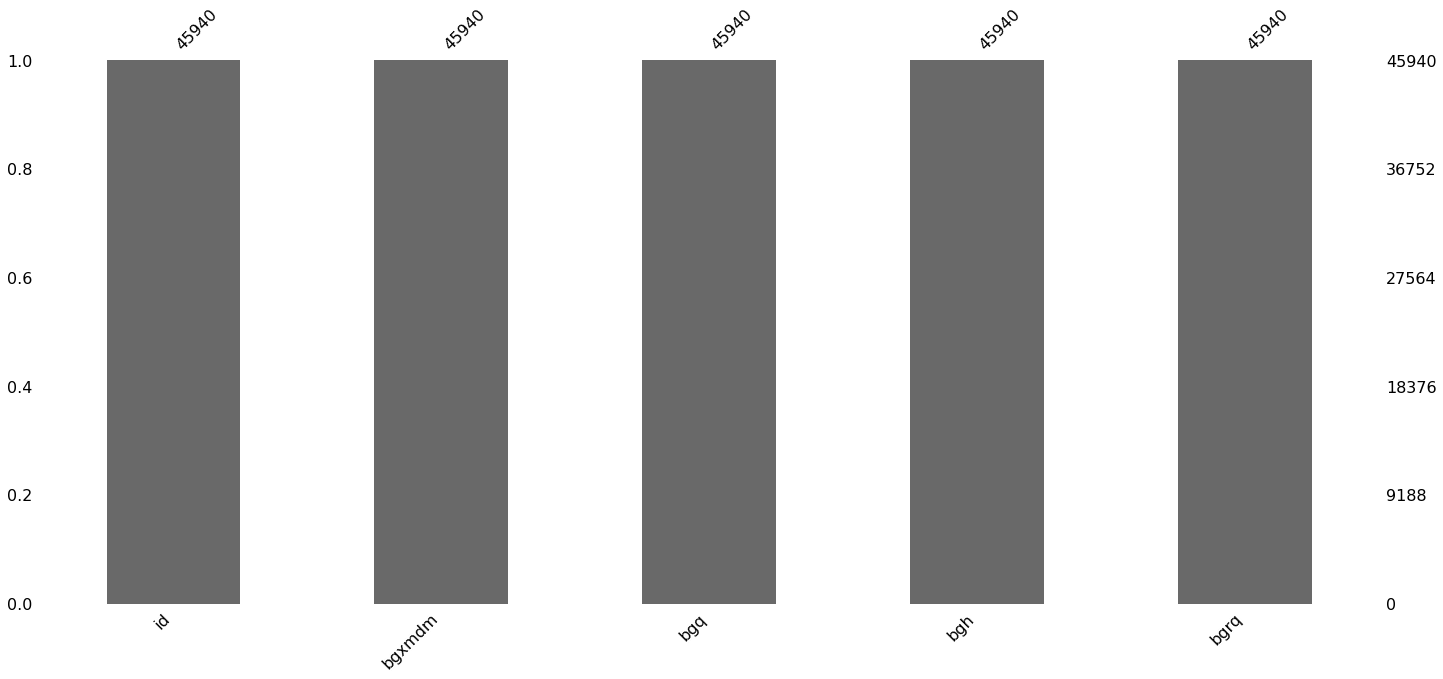

In [11]:
# 缺失值
msno.bar(change_info)

### 数据集5：news_info.csv

包含数据集7和8中涉及到的企业的新闻舆情信息，每一行代表一个企业新闻舆情，每一行3列，其中id列为企业唯一标识，列之间采用“,”分隔符分割。

数据格式如下：

|   列名   |  含义    |   列名   |   含义   | 
| ---- | ---- | ---- | ---- |
| id | 企业唯一标识 | positive_negtive | 新闻正负面性 |
| public_date | 发布日期 | |

In [12]:
news_info = pd.read_csv(PATH + 'news_info.csv')
news_info.head()

,id,positive_negtive,public_date
0,f000950527a6feb62669d6a175fe6fdccd1eb4f7ca8e5016,积极,2016-12-30
1,f000950527a6feb6e8bd9919e2ca363359bcfa997a0f9de7,中立,2017-08-09
2,f000950527a6feb6e8bd9919e2ca363359bcfa997a0f9de7,消极,2016-02-29
3,d8071a739aa75a3bcf6fb0041ee883243251d30025ab9d45,中立,2018-06-08
4,f000950527a6feb6d71de3382afa0bc5ff87bb65477f698a,积极,2015-06-29


### 数据集6：other_info.csv

包含数据集7和8中涉及到的企业的其他信息，每一行代表一个企业其他信息，每一行4列，其中id列为企业唯一标识，列之间采用“,”分隔符分割。

数据格式如下：

|   列名   |  含义    |   列名   |   含义   | 
| ---- | ---- | ---- | ---- |
| id | 企业唯一标识 | legal_judgment_num | 裁判文书数量 |
| brand_num | 注册商标数量 | patent_num | 专利数量|

In [13]:
other_info = pd.read_csv(PATH + 'other_info.csv')
other_info.head()

,id,legal_judgment_num,brand_num,patent_num
0,f000950527a6feb6d340f91da09e61347d8200cd2f0d1602,4.0,NaN,NaN
1,f000950527a6feb608dd9322b74a99f60851207f36a3c94c,1.0,NaN,NaN
2,d8071a739aa75a3b9f23966f8dae78fd226c272515b9c255,2.0,NaN,NaN
3,216bd2aaf4d079242209b1496f81a36c7abed9dd0bb65ed3,NaN,1.0,NaN
4,e9f7b28ec10e0470de9631c789f49acdd4e7cf9ed6db094b,NaN,2.0,NaN


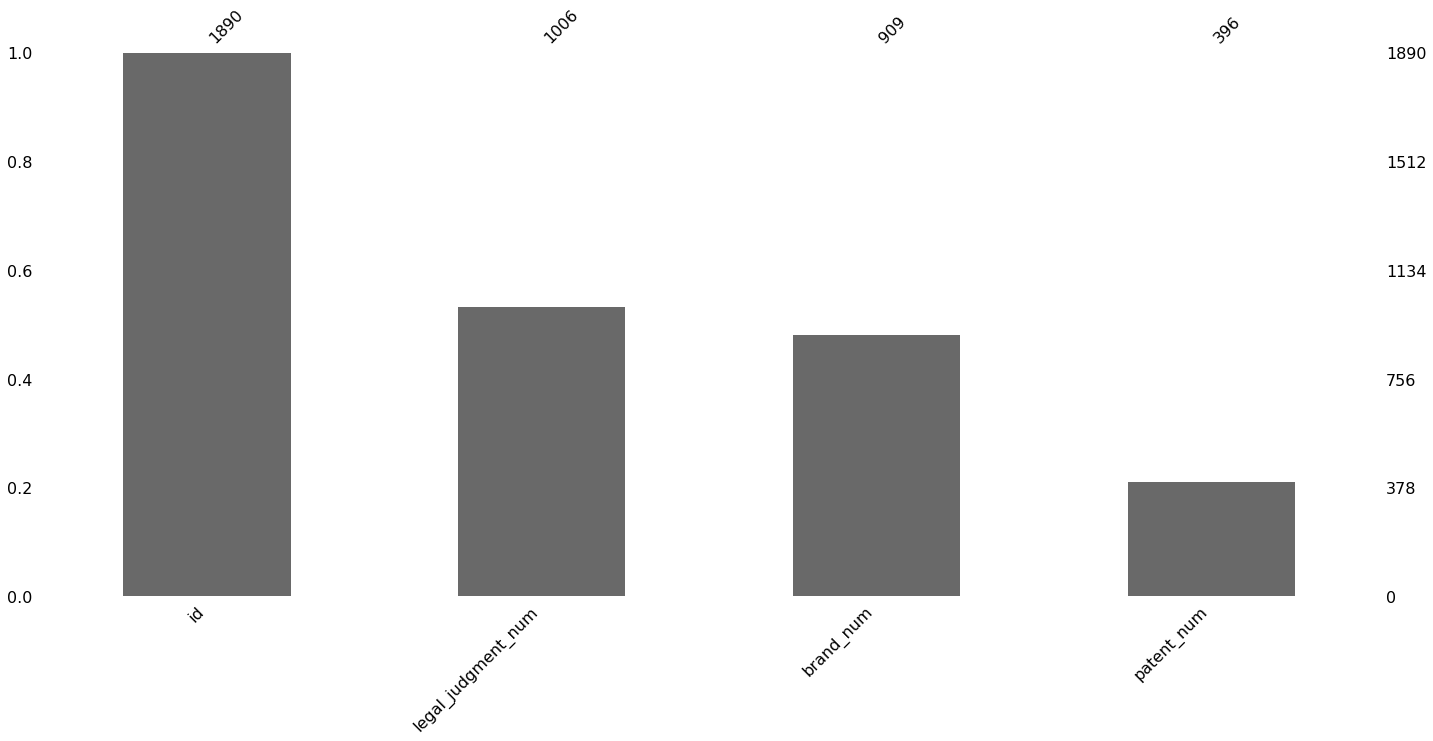

In [14]:
# 缺失值
msno.bar(other_info)

### 数据集7：entprise_info.csv

带标注的企业数据。每一行代表一个企业，每一行2列，其中id列为企业唯一标识，label列为标注（1：有非法集资风险，0：无非法集资风险），列之间采用“,”分隔符分割。

In [15]:
entprise_info = pd.read_csv(PATH + 'entprise_info.csv')
entprise_info.head()
entprise_info.shape

(14865, 2)

### 数据集8（验证集）：entprise_evaluate.csv

未标注企业数据。参赛队伍需提交的最终结果数据集，每一行代表一个企业，每一行有 2 列, 其中id列为企业唯一标识，score列为空，列之间采用“,”分隔符分割。

In [16]:
entprise_evaluate = pd.read_csv('../input/' + 'entprise_evaluate.csv')
entprise_evaluate.head()
entprise_evaluate.shape

(10000, 2)

## 提交要求

参赛者以csv文件提交：参赛者以csv文件格式，提交模型结果到大数据竞赛平台，平台进行在线评分，实时排名。目前平台仅支持单文件提交，即所有提交内容需要放在一个文件中。

## 评测标准

本赛题采用分类任务的精确率 P（precision）、召回率 R（recall） 和 F1 -score三个指标作为模型性能的评判标准。

| 真实结果 |         预测结果         |           描述           |
| :------: | :----------------------: | :----------------------: |
| 真实结果 |           正例           |           负例           |
|   正例   | TP(True Positive真正例)  | FN(False Negative假负例) |
|   负例   | FP(False Positive假正例) | TN(True Negative真负例)  |


在计算精确率、召回率和 F1-score时，系统会自动将提交结果中概率大于0.5的识别为1（有非法集资风险），概率小于等于0.5的识别为0（无非法集资风险）。

# 数据处理

In [17]:
def filter_col_by_nan(df, ratio=0.05):
    cols = []
    for col in df.columns:
        if df[col].isna().mean() >= (1-ratio):
            cols.append(col)
    return cols

In [18]:
# 剔除纯空列
base_info = pd.read_csv(PATH + 'base_info.csv')
base_info = base_info.drop(filter_col_by_nan(base_info, 0.01), axis=1)

annual_report_info = pd.read_csv(PATH + 'annual_report_info.csv')
annual_report_info = annual_report_info.drop(filter_col_by_nan(annual_report_info, 0.01), axis=1)

other_info = pd.read_csv(PATH + 'other_info.csv')
other_info = other_info[~other_info['id'].duplicated()]
other_info['other_SUM'] = other_info[['legal_judgment_num', 'brand_num', 'patent_num']].sum(1)
other_info['other_NULL_SUM'] = other_info[['legal_judgment_num', 'brand_num', 'patent_num']].isnull().astype(int).sum(1)


news_info = pd.read_csv(PATH + 'news_info.csv')
news_info['public_date'] = news_info['public_date'].apply(lambda x: x if '-' in str(x) else np.nan)
news_info['public_date'] = pd.to_datetime(news_info['public_date'])
news_info['public_date'] = (datetime.now() - news_info['public_date']).dt.days

news_info_df = news_info.groupby('id').agg({'public_date': ['count','max','min','mean']}).reset_index()
news_info_df.columns = ['id', 'public_date_COUNT', 'public_MAX', 'public_MIN', 'public_MEAN']
news_info_df2 = pd.pivot_table(news_info, index='id', columns='positive_negtive', aggfunc='count').reset_index()
news_info_df2.columns = ['id', 'news_COUNT1', 'news_COUNT2', 'news_COUNT3']
news_info_df = pd.merge(news_info_df, news_info_df2)

tax_info = pd.read_csv(PATH + 'tax_info.csv')
tax_info_df = tax_info.groupby('id').agg({
    'TAX_CATEGORIES': ['count'],
    'TAX_ITEMS': ['count'],
    'TAXATION_BASIS': ['count'],
    'TAX_AMOUNT': ['max', 'min', 'mean'],
})
tax_info_df.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() 
                                for e in tax_info_df.columns.tolist()])
tax_info_df = tax_info_df.reset_index()

change_info = pd.read_csv(PATH + 'change_info.csv')
change_info['bgrq'] = (change_info['bgrq'] / 10000000000).astype(int)

change_info_df = change_info.groupby('id').agg({
    'bgxmdm': ['count', 'nunique'],
    'bgq':['nunique'],
    'bgh': ['nunique'],
    'bgrq': ['nunique'],
})
change_info_df.columns = pd.Index(['changeinfo_' + e[0] + "_" + e[1].upper() 
                                for e in change_info_df.columns.tolist()])
change_info_df = change_info_df.reset_index()

annual_report_info = pd.read_csv(PATH + 'annual_report_info.csv')
annual_report_info_df = annual_report_info.groupby('id').agg({
    'ANCHEYEAR': ['max'],
    'STATE': ['max'],
    'FUNDAM': ['max'],
    'EMPNUM': ['max'],
    'UNEEMPLNUM': ['max', 'sum']
})
annual_report_info_df.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() 
                                for e in annual_report_info_df.columns.tolist()])
annual_report_info_df = annual_report_info_df.reset_index()


In [19]:
base_info['district_FLAG1'] = (base_info['orgid'].fillna('').apply(lambda x: str(x)[:6]) == \
    base_info['oplocdistrict'].fillna('').apply(lambda x: str(x)[:6])).astype(int)
base_info['district_FLAG2'] = (base_info['orgid'].fillna('').apply(lambda x: str(x)[:6]) == \
    base_info['jobid'].fillna('').apply(lambda x: str(x)[:6])).astype(int)
base_info['district_FLAG3'] = (base_info['oplocdistrict'].fillna('').apply(lambda x: str(x)[:6]) == \
    base_info['jobid'].fillna('').apply(lambda x: str(x)[:6])).astype(int)

base_info['person_SUM'] = base_info[['empnum', 'parnum', 'exenum']].sum(1)
base_info['person_NULL_SUM'] = base_info[['empnum', 'parnum', 'exenum']].isnull().astype(int).sum(1)

# base_info['regcap_DIVDE_empnum'] = base_info['regcap'] / base_info['empnum']
# base_info['regcap_DIVDE_exenum'] = base_info['regcap'] / base_info['exenum']

# base_info['reccap_DIVDE_empnum'] = base_info['reccap'] / base_info['empnum']
# base_info['regcap_DIVDE_exenum'] = base_info['regcap'] / base_info['exenum']

# base_info['congro_DIVDE_empnum'] = base_info['congro'] / base_info['empnum']
# base_info['regcap_DIVDE_exenum'] = base_info['regcap'] / base_info['exenum']

base_info['opfrom'] = pd.to_datetime(base_info['opfrom'])
base_info['opto'] = pd.to_datetime(base_info['opto'])
base_info['opfrom_TONOW'] = (datetime.now() - base_info['opfrom']).dt.days
base_info['opfrom_TIME'] = (base_info['opto'] - base_info['opfrom']).dt.days

base_info['opscope_COUNT'] = base_info['opscope'].apply(lambda x: len(x.replace("\t", "，").replace("\n", "，").split('、')))

cat_col = ['oplocdistrict', 'industryphy', 'industryco', 'enttype',
           'enttypeitem', 'enttypeminu', 'enttypegb',
          'dom', 'oploc', 'opform']

for col in cat_col:
    base_info[col + '_COUNT'] = base_info[col].map(base_info[col].value_counts())
    col_idx = base_info[col].value_counts()
    for idx in col_idx[col_idx < 10].index:
        base_info[col] = base_info[col].replace(idx, -1)        

# base_info['opscope'] = base_info['opscope'].apply(lambda x: x.replace("\t", " ").replace("\n", " ").replace("，", " "))
# clf_tfidf = TfidfVectorizer(max_features=200)
# tfidf=clf_tfidf.fit_transform(base_info['opscope'])
# tfidf = pd.DataFrame(tfidf.toarray())
# tfidf.columns = ['opscope_' + str(x) for x in range(200)]
# base_info = pd.concat([base_info, tfidf], axis=1)

base_info = base_info.drop(['opfrom', 'opto'], axis=1)

for col in ['industryphy', 'dom', 'opform', 'oploc']:
    base_info[col] = pd.factorize(base_info[col])[0]

In [20]:
train_data = pd.merge(base_info, entprise_info, on='id')
train_data = pd.merge(train_data, other_info, on='id', how='left')

train_data = pd.merge(train_data, news_info_df, on='id', how='left')
train_data = pd.merge(train_data, tax_info_df, on='id', how='left')
train_data = pd.merge(train_data, annual_report_info_df, on='id', how='left')
train_data = pd.merge(train_data, change_info_df, on='id', how='left')


entprise_evaluate = pd.read_csv('../input/' + 'entprise_evaluate.csv')
entprise_evaluate = entprise_evaluate[['id']]
test_data = pd.merge(base_info, entprise_evaluate, on='id')
test_data = pd.merge(test_data, other_info, on='id', how='left')
test_data = pd.merge(test_data, news_info_df, on='id', how='left')
test_data = pd.merge(test_data, tax_info_df, on='id', how='left')
test_data = pd.merge(test_data, annual_report_info_df, on='id', how='left')
test_data = pd.merge(test_data, change_info_df, on='id', how='left')


# train_data['enttypeminu_RANK'] = train_data['enttypeminu'].map(train_data.groupby(['enttypeminu'])['label'].mean().rank())
# train_data['enttypeitem_RANK'] = train_data['enttypeitem'].map(train_data.groupby(['enttypeitem'])['label'].mean().rank())
# test_data['enttypeminu_RANK'] = test_data['enttypeminu'].map(train_data.groupby(['enttypeminu'])['label'].mean().rank())
# test_data['enttypeitem_RANK'] = test_data['enttypeitem'].map(train_data.groupby(['enttypeitem'])['label'].mean().rank())



In [21]:
def eval_score(y_test,y_pre):
    _,_,f_class,_=precision_recall_fscore_support(y_true=y_test,y_pred=y_pre,labels=[0,1],average=None)
    fper_class={'合法':f_class[0],'违法':f_class[1],'f1':f1_score(y_test,y_pre)}
    return fper_class


def k_fold_serachParmaters(model,train_val_data,train_val_kind, test_kind):
    mean_f1=0
    mean_f1Train=0
    n_splits=5
    
    cat_features = ['oplocdistrict', 'industryphy', 'industryco', 'enttype',
           'enttypeitem', 'enttypeminu', 'enttypegb',
          'dom', 'oploc', 'opform']
    
    sk = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020)
    pred_Test = np.zeros(len(test_kind))
    for train, test in sk.split(train_val_data, train_val_kind):
        x_train = train_val_data.iloc[train]
        y_train = train_val_kind.iloc[train]
        x_test = train_val_data.iloc[test]
        y_test = train_val_kind.iloc[test]

        model.fit(x_train, y_train, 
                  eval_set=[(x_test, y_test)], 
                  categorical_feature = cat_features,
                 early_stopping_rounds=100,
                 verbose=False)
        
        pred = model.predict(x_test)
        fper_class = eval_score(y_test,pred)
        
        pred_Train = model.predict(x_train)
        pred_Test += model.predict_proba(test_kind)[:, 1]/n_splits
        fper_class_train = eval_score(y_train,pred_Train)

        mean_f1 += fper_class['f1']/n_splits
        mean_f1Train+=fper_class_train['f1']/n_splits
        # print(mean_f1, mean_f1Train)
        
        
    return mean_f1, pred_Test


In [22]:
score_tta = None
score_list = []

tta_fold = 20
for _ in range(tta_fold):
    clf = lgb.LGBMClassifier(
        num_leaves=np.random.randint(6, 10), min_child_samples= np.random.randint(2,5),
        max_depth=5,learning_rate=0.03,
        n_estimators=150,n_jobs=-1)

    score, test_pred = k_fold_serachParmaters(clf,
                           train_data.drop(['id', 'opscope','label'], axis=1),
                           train_data['label'],
                           test_data.drop(['id', 'opscope'], axis=1),
                          )

    if score_tta is None:
        score_tta = test_pred/tta_fold
    else:
        score_tta += test_pred/tta_fold
    # print(score)
    score_list.append(score)
    
print(np.array(score_list).mean(), np.array(score_list).std())
# 0.8478168974849689 0.83884757

# 0.8420447002972562 0.00198977186270193
# 0.8430490420761639 0.0022246925904664443

0.8401765998810908 0.0006742135572062399


In [23]:
test_data['score'] = score_tta

In [24]:
test_data[['id', 'score']].to_csv('tmp.csv', index=None)

In [703]:
lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [4,5,7],
              "learning_rate" : [0.01,0.05],
              "num_leaves": [5, 7, 8],
              "n_estimators": [50, 100, 150]
             }

cat_features = ['oplocdistrict', 'industryphy', 'industryco', 'enttype',
           'enttypeitem', 'enttypeminu', 'enttypegb',
          'dom', 'oploc', 'opform']

grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 5, scoring='f1', verbose=5)
grid_search.fit(train_data.drop(['id', 'opscope','label'], axis=1),
                           train_data['label'], categorical_feature = cat_features,)
grid_search.best_estimator_, grid_search.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['dom', 'enttype', 'enttypegb', 'enttypeitem', 'enttypeminu', 'industryco', 'industryphy', 'opform', 'oploc', 'oplocdistrict']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


(LGBMClassifier(learning_rate=0.05, max_depth=7, n_estimators=150, num_leaves=7,
                silent=False),
 0.8461400509259527)

In [647]:
base_info[['empnum', 'parnum', 'exenum']]

,empnum,parnum,exenum
0,5.0,NaN,NaN
1,3.0,NaN,NaN
2,2.0,1.0,NaN
3,2.0,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
24860,3.0,NaN,NaN
24861,2.0,2.0,1.0
24862,2.0,NaN,NaN
24863,3.0,NaN,NaN


In [711]:
train_data.corr()['label'].abs()[train_data.corr()['label'].abs() > 0.2]

industryphy                0.383172
industryco                 0.219334
enttypeitem                0.496364
townsign                   0.248114
parnum                     0.304170
enttypeminu                0.722564
regcap                     0.206842
person_NULL_SUM            0.360628
regcap_DIVDE_empnum        0.204050
opfrom_TONOW               0.381781
opfrom_TIME                0.498443
industryphy_COUNT          0.400440
enttype_COUNT              0.332443
enttypeitem_COUNT          0.437443
enttypeminu_COUNT          0.549604
enttypegb_COUNT            0.411440
label                      1.000000
public_MAX                 0.363826
public_MIN                 0.205591
public_MEAN                0.368823
changeinfo_bgrq_NUNIQUE    0.232512
Name: label, dtype: float64

0        4.0
1        4.0
2        NaN
3        NaN
4        NaN
        ... 
14860    9.0
14861    NaN
14862    4.0
14863    NaN
14864    4.0
Name: enttypeminu, Length: 14865, dtype: float64

In [16]:
base_info

,id,oplocdistrict,industryphy,industryco,dom,opscope,enttype,enttypeitem,opfrom,opto,state,orgid,jobid,adbusign,townsign,regtype,empnum,compform,parnum,exenum,opform,ptbusscope,venind,enttypeminu,midpreindcode,protype,oploc,regcap,reccap,forreccap,forregcap,congro,enttypegb
0,47645761dc56bb8c5fae00114b768b5d9b6e917c3aec07c4,340223,M,7513.0,31487d8f256f16bd6244b7251be2ebb24d1db51663c654...,纳米新材料、机械设备、五金配件加工、销售及技术推广服务，道路货物运输。（依法须经批准的项目，...,1100,1150.0,2019-07-11 00:00:00,NaN,6,340223010010000000,340200000000115392,0,0,1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1151.0,NaN,NaN,2367b4cac96d8598,50.0,NaN,NaN,NaN,NaN,1151
1,9c7fa510616a683058ce97d0bc768a621cd85ab1e87da2a3,340222,O,8090.0,31487d8f256f16bd6244b7251be2ebb27b17bdfd95c8f3...,健身服务。（依法须经批准的项目，经相关部门批准后方可开展经营活动）,9600,NaN,2017-09-06,NaN,6,340222060010000000,340200000000112114,0,1,1,3.0,1.0,NaN,NaN,10,NaN,3.0,NaN,NaN,NaN,31487d8f256f16bd6244b7251be2ebb27b17bdfd95c8f3...,10.0,NaN,NaN,NaN,NaN,9600
2,59b38c56de3836838082cfcb1a298951abfe15e6940c49ba,340202,R,9053.0,31487d8f256f16bd6244b7251be2ebb2ae36cd652943e8...,文化娱乐经纪人服务；境内文艺活动组织与策划；文化艺术交流活动组织策划；演出经纪；其他文化艺术...,1100,1150.0,2020-09-14 14:46:30,NaN,6,340202010010000000,400000000000753910,0,0,1,2.0,NaN,1.0,NaN,NaN,NaN,NaN,1151.0,NaN,NaN,2367b4cac96d8598,100.0,NaN,NaN,NaN,NaN,1151
3,e9f7b28ec10e047000d16ab79e1b5e6da434a1697cce7818,340221,L,7212.0,746df9aaed8578571760c563abe882c8ba25209fc6d5db...,投资管理及咨询(证券、期货除外)；企业管理。（依法须经批准的项目，经相关部门批准后方可开展经...,4500,4540.0,2015-09-30,NaN,6,340221010010000000,400000000000013538,0,1,1,2.0,NaN,NaN,NaN,01-以个人财产出资,NaN,NaN,NaN,NaN,NaN,2367b4cac96d8598,10.0,NaN,NaN,NaN,NaN,4540
4,f000950527a6feb63ee1ce82bb22ddd1ab8b8fdffa3b91fb,340202,R,8810.0,31487d8f256f16bd6244b7251be2ebb2ae36cd652943e8...,境内文化艺术交流活动策划；企业形象策划；礼仪庆典服务；翻译服务；专利代理；广告设计、制作、代...,1100,1130.0,2017-12-01,2067-11-30,7,340200000000000000,400000000000283237,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2367b4cac96d8598,100.0,NaN,NaN,NaN,NaN,1130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24860,f1c1045b13d18329a2bd99d2a7e2227688c0d69bf1d1e325,340225,O,8131.0,31487d8f256f16bd6244b7251be2ebb227ca54d864983f...,家电销售、维修及安装服务。（依法须经批准的项目，经相关部门批准后方可开展经营活动）,9600,NaN,2009-02-20 00:00:00,NaN,6,340200000000116780,341400000000011622,0,1,1,3.0,1.0,NaN,NaN,10,NaN,3.0,NaN,NaN,NaN,f67c1b92f52ac52e424308ab51241cdef9be3e39c8e1c6...,20.0,NaN,NaN,NaN,NaN,9600
24861,f000950527a6feb6bde38216d7cbbf32e66d3a3a96d4dbda,340207,J,6790.0,31487d8f256f16bdb06579d53b25cbb6c4a6c18662c495...,股权投资，投资管理，投资咨询。（依法须经批准的项目，经相关部门批准后方可开展经营活动）***,4500,4530.0,2015-12-18,2065-12-17,6,340200000000000000,340200000000115797,0,1,1,2.0,NaN,2.0,1.0,NaN,NaN,NaN,4533.0,NaN,NaN,2367b4cac96d8598,110.0,0.0,NaN,NaN,NaN,4533
24862,da8691b210adb3f65b43370d3a362f4aa1d3b16b5ba0c9d7,340207,O,8111.0,ca213febe80e171c3b9617e39b49d64e4a4abca4f2d760...,快速喷漆、电路机维修、汽车美容装潢、汽车维修服务。（依法须经批准的项目，经相关部门批准后方可...,9600,NaN,2012-05-31 00:00:00,NaN,6,340207030010000000,340200000000115275,0,1,1,2.0,1.0,NaN,NaN,10,NaN,3.0,NaN,NaN,NaN,2367b4cac96d8598,10.0,NaN,NaN,NaN,NaN,9600
24863,516ab81418ed215dcbbf0614a7b929e691f8eed153d7bb31,340225,O,8090.0,31487d8f256f16bd6244b7251be2ebb227ca54d864983f...,一般经营项目：园林设计、市政绿化、假山工艺、苗圃栽培。,1100,1130.0,2012-10-16 00:00:00,NaN,7,340200000000116750,341400000000015220,0,1,1,3.0,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2367b4cac96d8598,260.0,260.0,NaN,NaN,NaN,1130
